# Introduction to network comparison

CMT224: Social Computing

<br>
<br>

## Case Study

## Dataset: GitHub Commits

>![GitHub][1]
>
> GitHub, Inc. is a provider of Internet hosting for software development and version control using Git. It offers the distributed version control and source code management (SCM) functionality of Git, plus its own features. It provides access control and several collaboration features such as bug tracking, feature requests, task management, continuous integration and wikis for every project. -- Wikipedia
>
> GitHub is of course not a social media website and casual social features are arguably not its core function. However, interaction between individuals is often a fundamental trait of its features, particularly for public/team projects. E.g., collaboration on code bases, issue tracking, wikis, etc. Therefore, a secondary benefit of the data being generated as part of repository operation is the ability to analyse aspects of collaboration behaviours.

[1]: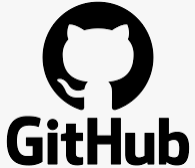



- We will explore this by modelling the commit data in a similar way to a social network with nodes as users and in a similar way to what has been undertaken for other collaborative platforms such as Wikipedia (e.g., https://arxiv.org/abs/1904.08139). We will use commit histories of various public repositories, including some from the same organisation. Exploring the commit history data does not provide an exhaustive proxy for the individual collaborative behaviours and cultures between developers, but it does provide a basis for simple, comparable modelling that we can compare against social phenomena seen more generally.

- We will also use this as the basis to explore how networks of different sizes, structures, and content can be compared, through comparing the commit behaviours between repositories and within repositories over time.

- The data used in this notebook is a subset of a larger dataset available at: https://www.kaggle.com/dhruvildave/github-commit-messages-dataset


---

<font color="#F4A460">This exercise assumes a Python 3 ipykernel environment. </font>

<font color="#F4A460"> If you are not running a virtual environment, run the cell below. Then go to "Kernel" on the top menu and click "Restart Kernel". Or if you are running a virtual environment, install networkx, matplotlib, etc, and jupyter/ipykernel in the virtual environment instead. </font>


In [12]:
%pip install networkx numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---

In [13]:
import networkx as nx
import csv
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np
import glob
import operator


<br>
<br>

## 1. Building networks from the GitHub commit data

### Understanding the raw dataset

Here we don't have pre-built networks to analyse, we must instead build a suitable network or networks from the data first and then undertake the analysis. The dataset in question is a collection of 34 CSV files, each spanning 12-months of commit behaviour for a single, public GitHub repository.

- Each row in a CSV file represents an individual commit and has two columns: The first is a user id and the second is the date and time the commit. The CSV files do not have headers.
- User ids are pseudonymised from GitHub usernames and shared across the data files (repositories).
- The commits for each repository have been pre-sorted in date and time descending order.

Example commit information from the dataset:
```csv
	115089	31/12/2020 13:35:52 +0100
	118185	27/12/2020 19:34:16 +0100
	118185	24/12/2020 12:06:01 +0100
	118118	23/12/2020 16:37:20 -0800
```


<br>
<br>

### Creating a network from commit behaviour with NetworkX

The data files contains commit behaviour for a single repository, however some users commit to multiple repositories. 

As a result, there are different ways a network structure could be constructed. For example, we could build a 'social network' of users with connections between users that commit to the same repository. Another example could be to build a network that embeds the order in which users commit to a repository to model the potential collaboration interplay between developers.

We first need to define a scope for the network (or networks) based on some overarching research question(s) or hypothesis/hypotheses. 

This *could be*: **Do patterns in cumulative commit data expose similarities or differences in the collaborative behaviour of public software projects?**

<br>
<br>

#### Choosing a type of Graph

A key component of the data is the temporal component of the rows (commits), whereby one commit comes after another or put another way one person commits to a repository after someone else.

Lets refer to the NetworkX documentation for a list of different types of Graphs (that it supports):

https://networkx.org/documentation/stable/reference/classes/index.html

Two immediate choices given what the edges could represent are a **Directed MultiGraph (MultiDiGraph object)** or a **Directed Graph (DiGraph object)**.

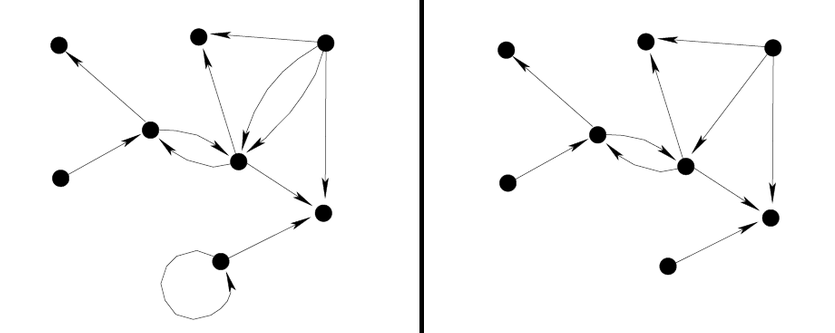

-- Lopez and Burcet (2012)

A **Directed MultiGraph** may be seen as the most appropriate choice as the data likely contains multiple instances where someone commits after someone else. Directed MultiGraphs can be seen as more complex to analyse with many 'traditional' graph theory methods available concentrating on Undirected or Directed graphs (although many have extensions continuing to be proposed in research papers). They can also offer more opportunities for a richer analysis where, for example, temporal data is embedded on the edges (see Extra: Temporal motifs).

Instead, the data could be represented as a **Directed Graph, with edge weights** that represent the number of times someone commits after someone else. This has the benefit of allowing weights to be considered for some analyses and not for others - much like the Reddit hyperlink notebook.


> **Extra**: Temporal motifs: https://snap.stanford.edu/temporal-motifs/

For this notebook, we will choose the later and focus on examining and comparing commit behaviour across and within repositories. Extending this with a Directed MultiGraph would be a good considering for future work as part of your independent study.


<br>
<br>

In [14]:
commit_file = "data/jupyterlab+jupyterlab.csv" # For simplicity initially, we will only process the data from one repository.

G = nx.DiGraph() # create an empty NetworkX DiGraph object

To help contextualise what we wish to achieve, lets consider the following simplified example. Assume that a repository only has 4 commits in total sorted in time descending order as below: 

```csv
	 (user) (date and time of the commit)
row 1	3 	31/12/2020 11:37:52 +0100
row 2	9 	27/12/2020 14:34:23 +0100
row 3	17	23/12/2020 16:37:19 -0800
row 4	3	23/12/2020 12:11:04 -0800
```

Here we loop through the data to create a directed network by looping over each row and creating an edge (or increasing the weight) from the user in row $n$ to the user in row $n+1$. We want the resulting network to have the following edges:

    3 -> 9    i.e, user 3 committed after user 9
    
    9 -> 17    i.e, user 9 committed after user 17
    
    17 -> 3    i.e, user 17 committed after user 3

Alternatively, the network model could be built to represent edges in the opposite direction, i.e., a user commits *before* another user.

<br>

In [15]:
# Use Python's csv package to read each line of the csv file
with open(commit_file) as csvfile:
    reader = csv.reader(csvfile)

    user_of_the_next_commit = next(reader)[0] # move the iterator along by 1, getting the user id of the first row (final commit of the year)

    for i, commit in enumerate(reader): # for each row in the file (commit to the repository)
        user_of_this_commit = commit[0] # extract out the user id, the first column

        if G.has_edge(user_of_the_next_commit, user_of_this_commit):                 # if the network already has an edge between the users
            G[user_of_the_next_commit][user_of_this_commit]["weight"] += 1           #  increment the weight attribute on the edge by 1
        else:                                                                        # otherwise if the network does not already have the edge
            G.add_edge(user_of_the_next_commit, user_of_this_commit, weight = 1)     #  add the edge with an initial weight attribute value of 1
            
        # importantly, the user_of_this_commit being processed should now replace the existing user_of_the_next_commit      
        # 'next' here refers to 'next' in a temporal sense as the file is sorted by time in descending order, i.e., not the 'next' row to be processed
        user_of_the_next_commit = user_of_this_commit

        

Or put another way. Firstly, process the first row by just extracting out the user:

   user_of_the_next_commit = ***3***

Then start looping over each of the other commits (i.e., starting from the second row):

   1. user_of_this_commit = **9**
   2. create an edge from ***3*** to **9**
   3. user_of_the_next_commit now = **9**

Now consider the third row:

   1. user_of_this_commit = *17*
   2. create an edge from **9** to *17*
   3. user_of_the_next_commit now = *17*

Now consider the fourth row:

   1. user_of_this_commit = ***3***
   2. create an edge from *17* to ***3***
   3. user_of_the_next_commit now = ***3***

No more rows.


<br>
<br>


Lets examine some structural properties of the created network. Refer back to the notebooks in previous weeks for more information on each measure.


In [16]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Total of edge weights: {G.size(weight='weight')} (Number of commits - 1) \n")

print(f"Number of strongly connected components: {nx.number_strongly_connected_components(G)}")
print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G)}")

Number of nodes: 126
Number of edges: 677
Total of edge weights: 3540.0 (Number of commits - 1) 

Number of strongly connected components: 1
Number of weakly connected components: 1


Some immediate observations:

- The number of edges and the total weight on the edges is relatively small in comparison to the other notebooks seen so far (e.g. Reddit hyperlinks);
- The network is unsurprisingly weakly connected, but perhaps more surprisingly is also strongly connected.

As the number of nodes and edges is reasonably small, lets visualise the network:

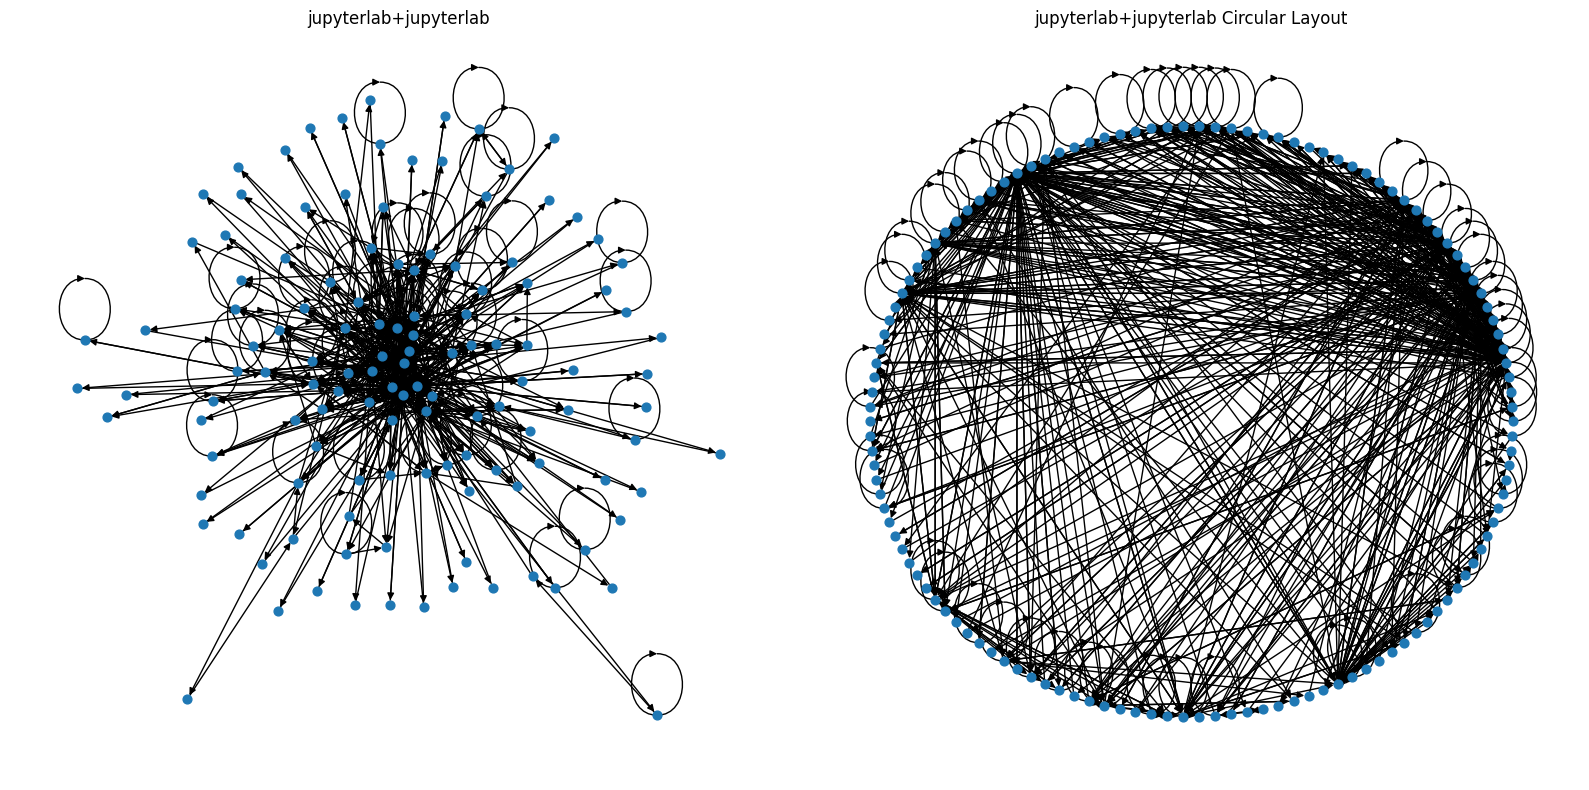

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
nx.draw(G, ax=ax1, node_size=40)
nx.draw_circular(G, ax=ax2, node_size=40)
ax1.set_title("jupyterlab+jupyterlab")
ax2.set_title("jupyterlab+jupyterlab Circular Layout")
plt.tight_layout()
plt.show()

<br>
<br>

### Self loops?

This is the first time we have seen a case where a node has an edge going from itself to itself. This is called a 'self loop'. On reflection, this is perhaps unsurprising here as Git repositories do not assume that different people will be committing each time.

However, this creates another decision point in the modelling of the network as to whether self loops should be kept or removed from the network.

Here we are less concerned about the commit behaviours of a single a user, and some of the analysis methods we will use will ignore them, so we will opt for removing them here. However, this is something to consider exploring further as an optional "Extra:" task in independent study.

To remove the edges from the network we could either add an additional check during the building of the network, similar to the check about whether an edge already exists or we can remove all the edges afterwards. We will do the later for simplicity and use the following NetworkX DiGraph function which can be called from any graph object:

```python
G.remove_edges_from(..)
```

https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.remove_edges_from.html

The method requires a list of edges to remove from the network. Fortunately, NetworkX has a convenient method for getting the list of all edges that are self loops in a given Network:

```python
nx.selfloop_edges(..)
```

https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.selfloop_edges.html

So to remove all self loops from our network we can combine calls to these two calls as below:

In [18]:
G.remove_edges_from(nx.selfloop_edges(G))

> **Extra**: Modify the cell above to investigate and confirm that the operation does as intended. e.g., Print and compare the number of edges with the output of the earlier cell, re-visualise the network as a plot, etc.

<br>
<br>

### Building multiple networks

The notebook so far has concentrated on building the network to model the commit behaviour of a single repository. However here we want to compare the behaviour (i.e., network structure) of multiple repositories. To do this we will define a new Python method that will take a csv file representing commits for a repository, create a network in the same way the previous cells above, and then return the created network from the method.

We will use a Python dictionary to store our networks together, the keys will be the names of the account owning the repository + the repository names (the same as the filenames for the csv files) and the values will be NetworkX DiGraph objects, e.g.

```python
{
    "juputerlab+jupyterlab" : A DiGraph object,
    "microsoft+vscode" : A DiGraph object,
    ...
}
```

In [19]:
# Define a Python function with one argument, the file path and name of the CSV file that we want to build a network from.
def commitsToNetwork(fn):
    
    # Build the network as a NetworkX DiGraph for the given CSV file:
    
    # The following lines are the same as the code cell below the "Choosing a type of Graph" cell earlier in the notebook.
    # Comments for each line are not present here, so refer back to the previous cell for any that you are unsure about.
    
    G = nx.DiGraph()
    
    with open(fn) as csvfile:
        reader = csv.reader(csvfile)

        user_of_the_next_commit = next(reader)[0] 
        
        for i, commit in enumerate(reader): 
            user_of_this_commit = commit[0] 

            if G.has_edge(user_of_the_next_commit, user_of_this_commit):                 
                G[user_of_the_next_commit][user_of_this_commit]["weight"] += 1          
            else: 
                G.add_edge(user_of_the_next_commit, user_of_this_commit, weight = 1)

            user_of_the_next_commit = user_of_this_commit
            
    # Once the network has been built, remove any self loops that are present
    G.remove_edges_from(nx.selfloop_edges(G))

    # Return the completed network (DiGraph) object
    return G

<br>
<br>

In [20]:
commitNetworks = {} # create the Python dictionary to hold our network objects

for filename in glob.glob("data/*.csv"): # for each csv file in the folder "data" (assumes that "data" is in the same directory as this notebook)
    
    repo = filename[5:-4] # this implementation is simple but inflexible to changes in the filepath for the files. You could replace this with something more robust
    
    # create the network DiGraph object for the csv file with that filename using the method defined in the previous code cell, and add it to the dictionary
    commitNetworks[repo] = commitsToNetwork(filename) 

> **Extra**: The above cell uses the Python package 'glob' to do the heavy lifting in getting the file paths and names of the csv files we use. It is just one way of traversing file systems in Python. To learn more about the package, read the following article: https://towardsdatascience.com/the-python-glob-module-47d82f4cbd2d

<br>
<br>

Now that we have a dictionary of networks, one for each repository/csv file, lets loop over and print some basic network measures/statistics about each of the networks to give an early indication of the similarity/differences between them.

In [21]:
for repo, network in commitNetworks.items():  # for each item in the dictionary, print
    print(f"Repository: {repo}\n"                  # the account+repository name, e.g. jupyterlab+jupyterlab
          f"#Nodes: {network.number_of_nodes()}   " # the number of nodes in the network
          f"#Edges: {network.number_of_edges()}   " # the number of edges in the network
          f"Total Weight: {network.size(weight='weight')}   " # the total weight on all edges in the network
          f"Is Strongly Connected: {nx.is_strongly_connected(network)}\n" # whether the network is strongly connected
    )


Repository: angular+angular
#Nodes: 343   #Edges: 1377   Total Weight: 2273.0   Is Strongly Connected: True

Repository: apache+httpd
#Nodes: 21   #Edges: 110   Total Weight: 304.0   Is Strongly Connected: True

Repository: apache+spark
#Nodes: 341   #Edges: 1807   Total Weight: 2666.0   Is Strongly Connected: True

Repository: apple+swift
#Nodes: 271   #Edges: 3484   Total Weight: 13523.0   Is Strongly Connected: True

Repository: chromium+chromium
#Nodes: 2441   #Edges: 74552   Total Weight: 107281.0   Is Strongly Connected: True

Repository: denoland+deno
#Nodes: 382   #Edges: 1215   Total Weight: 2025.0   Is Strongly Connected: True

Repository: facebook+react
#Nodes: 161   #Edges: 425   Total Weight: 805.0   Is Strongly Connected: True

Repository: freebsd+freebsd-src
#Nodes: 193   #Edges: 2906   Total Weight: 5383.0   Is Strongly Connected: True

Repository: gcc-mirror+gcc
#Nodes: 361   #Edges: 3639   Total Weight: 7098.0   Is Strongly Connected: True

Repository: golang+go
#Node


Some observations:

- The number of users committing the repositories vary considerably across the networks;
- As does the number of edges and edge weight;
- Most of the networks are strongly connected, but there are a few exceptions - e.g. the final node/user added to the network does not commit after another node/user.


Going forward this motivates caution in comparing the structural properties of the networks further and drawing conclusions on the similarities and differences found and how these may link to collaboration behaviour. To help overcome this we will compare the networks using various methods that are independent of the number of nodes and edges in the network (i.e., normalised). 



<br>
<br>

---

<br>
<br>


## 2. How similar/different is the commit behaviour across repositories? 

Lets firstly utilise network measures that we've seen and used before in other notebooks that are 'global' in measuring/summarising something across the network and are independent of the number of nodes and edges.

### Size-independent, global network measures.

In [22]:
# Create a Python list of lists where each sub-list contains the values of a particular network measure across all of our networks.

measures = [[nx.density(network) for network in commitNetworks.values()],               # calculate the density of each network
            [nx.reciprocity(network) for network in commitNetworks.values()],           # calculate the overall reciprocity of each network
            [nx.average_clustering(network) for network in commitNetworks.values()],    # calculate the average (local) clustering of each network
            [nx.transitivity(network) for network in commitNetworks.values()]]          # calculate the transitivity of each network


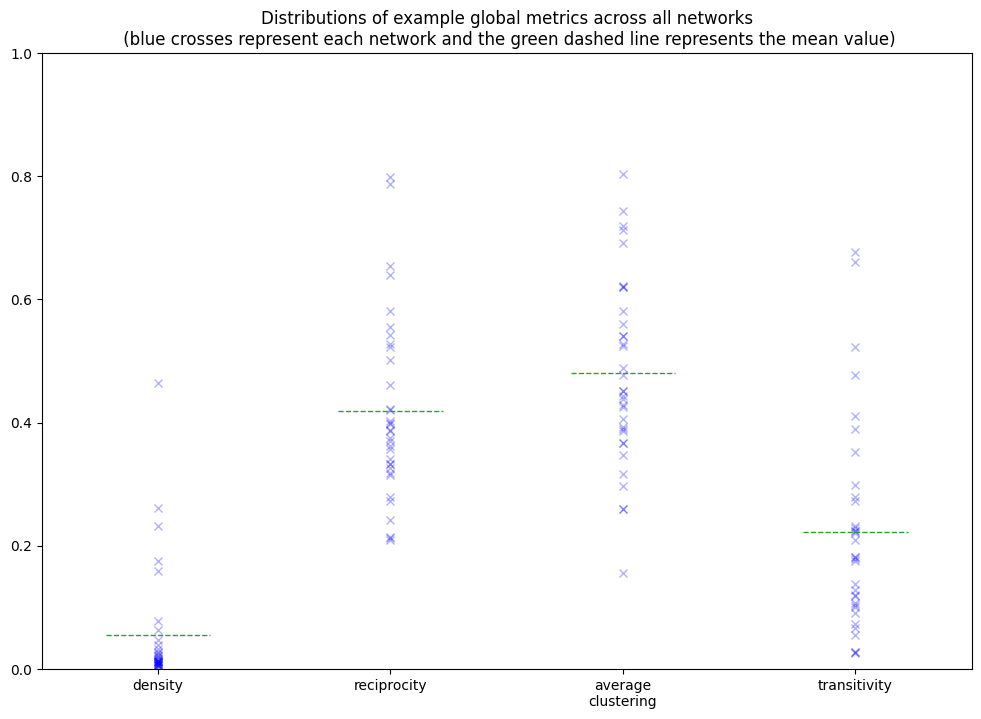

In [23]:
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.set_title("Distributions of example global metrics across all networks\n (blue crosses represent each network and the green dashed line represents the mean value)")
ax1.set_ylim(0,1)

# Create a boxplot but turn off all visual features other than the mean line
bp = ax1.boxplot(
    x=measures,
    tick_labels=["density", "reciprocity", "average\nclustering", "transitivity"],
    showfliers=False,
    showbox=False,
    showcaps=False,
    whis=0,
    showmeans=True,
    meanline=True,
    medianprops=dict(linewidth=0)
)

# Plot the distribution of the data on top of the (invisible) boxplots
for i in range(0,4):
    y_values = measures[i]
    x_values = np.random.normal(i+1, 0.0, size=len(y_values))
    ax1.plot(x_values, y_values, 'bx', alpha=0.3)

plt.show()



> **Extra**: Transitivity recap, see Twitch notebook for more information https://transportgeography.org/contents/methods/graph-theory-measures-indices/transitivity-graph/



Some observations:

- The majority of the networks are very sparse;
- However, reciprocity, local average clustering, and global transitivity vary considerably across the networks.

This suggests that from the perspective of the handful of individual networks measures used, the networks are arguably more structurally dissimilar than similar and this is therefore indicative of dissimilarity in collaboration behaviour as expressed from the specific analysis lens of by commit ordering.

<br>
<br>

However this only considers some specific perspectives of how the network structure can be analysed and represented. To explore this further, we can look at alternative perspectives such as paths:

In [57]:
#In some (outdated) NetworkX versions, the average shortest path lengths for directed networks are calculated only where nodes are reachable. 
#In newer versions of NetworkX, a Python Exception is raised if the network is not strongly connected.

#Calculate the average shortest path length for networks that are strongly connected.
sp = [nx.average_shortest_path_length(network) for network in commitNetworks.values() if nx.is_strongly_connected(network)] 

print("Average shortest path length across the networks:\n")

print(f"Number of networks={len(sp)}/{len(commitNetworks)}\n"
      f"Mean={np.mean(sp):.2f}\n"
      f"Median={np.median(sp):.2f}\n"
      f"SD={np.std(sp):.2f}\n"
      f"Min={np.amin(sp):.2f}\n"
      f"Max={np.amax(sp):.2f}\n"
     )

Average shortest path length across the networks:

Number of networks=30/34
Mean=2.86
Median=2.92
SD=0.54
Min=1.56
Max=4.10



While not a size-independent network measure, the average shortest path across the networks is similar. This provides an initial indication that the networks may be driven to some extent by some similar characteristics of the underlying collaboration behaviour.


<br>
<br>

### Sub-structures in Networks: Triads

It has been argued in the Network Science field that complex networks representing real-world phenomena (and not exclusive to social behaviour) are built from 'building blocks', small subgraphs containing 3 or more nodes, rather than strict dyadic edges between nodes. 

> **Extra**: Milo, R., Shen-Orr, S., Itzkovitz, S., Kashtan, N., Chklovskii, D., & Alon, U. (2002). Network motifs: simple building blocks of complex networks. Science, 298(5594), 824-827.
> http://sdcsb.ucsd.edu/wp-content/uploads/2013/10/Science-2002-Milo-824-7.pdf

and that 'superfamilies' of types of network structures can be seen when comparing the abundance or scarcity of particular building block subgraphs:

> **Extra**: Milo, R., Itzkovitz, S., Kashtan, N., Levitt, R., Shen-Orr, S., Ayzenshtat, I., ... & Alon, U. (2004). Superfamilies of evolved and designed networks. Science, 303(5663), 1538-1542.
> http://stat.asu.edu/~dieter/courses/APM_598/Alon_science.pdf


We've seen a small aspect of this in previous notebooks that highlighted the dominance of triangles (local clustering coefficient) in 'small-world' networks. To take this a step further, we will examine all of the possible ways that 3 nodes in a directed network can be connected together (triads) and then count how many of each occur in the GitHub Commit networks, i.e., create a 'census' of triads that exist in each network. If the proportion of each triad is similar then we will have some evidence that GitHub commit behaviour networks are comprised of specific building blocks.


Firstly, lets consider all of the possible ways that 3 nodes in a network can be connected (or not connected):

![Triads][1] - Lienert et al

> The labels above each triad can be interpreted as follows:
>
>https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.triads.triad_type.html#networkx.algorithms.triads.triad_type
>
>{m}{a}{n}{type} (for example: 111D, 210, 102)
>
>Here:
>
>{m} = number of mutual ties/edges
>
>{a} = number of assymmetric ties/edges
>
>{n} = number of null ties/edges
>
>{type} = a letter (takes U, D, C, T) corresponding to up, down, cyclical and transitive. This is only used for topologies that can have more than one form (eg: 021D and 021U).


[1]: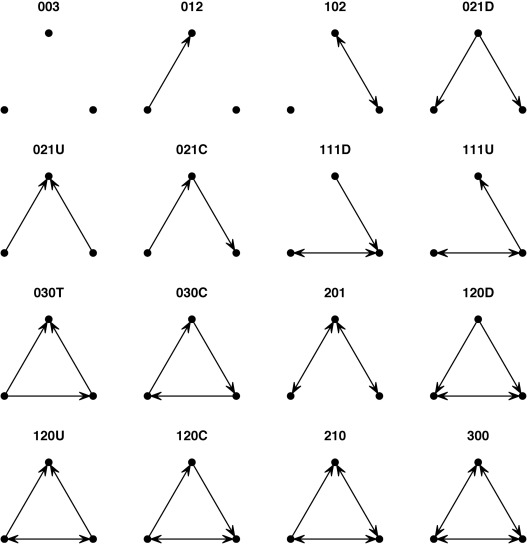

#### Triadic census

NetworkX has a method, that will count the number of times each type of triad occurs in a given network, i.e., the 'triadic census':

```python
nx.triadic_census(..)
```

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.triads.triadic_census.html


To demonstrate this, lets calculate the triadic census for the jupyterlab network:

In [63]:
# The following will return a dictionary where keys are the triad labs (defined in the cells above) 
# and the values are the number of times the triads occur in the network.

nx.triadic_census(commitNetworks["jupyterlab+jupyterlab"])


{'003': 280203,
 '012': 22900,
 '102': 13929,
 '021D': 573,
 '021U': 547,
 '021C': 1105,
 '111D': 1975,
 '111U': 2006,
 '030T': 28,
 '030C': 26,
 '201': 1467,
 '120D': 35,
 '120U': 54,
 '120C': 150,
 '210': 269,
 '300': 233}

In the output you will see that the following triad types occur much more frequently than the others: $003$, $012$, and $102$. These three triads are special in that, from one perspective, they arguably capture **what edges are not in the network**. 

To contextual this, we can consider the triadic census as something that simply looks at every combination of 3 nodes that exist in the network. In this case there are 126 nodes in our network, and mathematically there are 325,500 combinations of 3 nodes that can be made from this irrespective of whether edges exist between these combinations of 3 or not. The sum of the triadic census values will equal the number of combinations of 3 (i.e., in this case 325,500). 

So what $003$ is actually counting is the number of combinations of 3 nodes in the networks where no edges exist between them. Importantly, these nodes are not necessarily disconnected (with a degree of 0) but just that no edges exist between the 3 nodes in the combination. As the network is sparse (as seen from the density measure earlier), this number is unsurprisingly high.

Similarly, $012$ is counting the number of combinations where one edge exists between 2 of the 3 nodes, but not the other node in the combination. Likewise for $102$.

> **Extra**: Modify the cell above to check and confirm that the sum of the values in the triadic census is equal to the number of combinations of 3 that can be made from a set of 126 nodes (325,500).


<br>
<br>

#### Connected triads

However, it is common practice when comparing networks using small induced subgraphs such as triads to focus on "Connected" combinations and discard the other node combinations.

Lets define a Python method that will perform the NetworkX triadic census operation, remove the counts for $003$, $012$, and $102$, and then normalise the remaining 13 values so that they sum to 1. This will give us a comparable, size-independent measure between networks of different number of nodes, edges, and triad occurrences. 

In [24]:
def calculate_normalised_connected_triadic_census(H):
    
    # Calculate the triadic census
    tc = nx.triadic_census(H)

    # Remove the non-connected triads
    del tc["003"]
    del tc["012"]
    del tc["102"]
    
    # Normalise the values to be between 0 and 1
    factor = 1.0 / sum(tc.values())
    for k in tc:
        tc[k] = round(tc[k] * factor, 3) #round to 3dp for readability here
    
    return tc

calculate_normalised_connected_triadic_census(commitNetworks["jupyterlab+jupyterlab"])

{'021D': 0.068,
 '021U': 0.065,
 '021C': 0.13,
 '111D': 0.233,
 '111U': 0.237,
 '030T': 0.003,
 '030C': 0.003,
 '201': 0.173,
 '120D': 0.004,
 '120U': 0.006,
 '120C': 0.018,
 '210': 0.032,
 '300': 0.028}

If you multiplied the values by 100.0, they would represent the percentage of all triad occurrences are a particular type of triad. For example, ~17% of triad occurrences in the jupyterlab network is triad $201$.

<br>
<br>

#### Comparing normalised censuses

Lets calculate the normalised triadic census for all networks, rather than just 'jupyterlab+jupyterlab' in the cell above, to then compare how similar the values of each triad type are across the networks.

(It will take a little while to run.)

In [25]:
# Calculate normalised triadic censuses for each commit network

# Create an empty dictionary, keys will be repositories and values will be another dictionary, the normalised triadic census like the cell above
normalised_triadic_censuses = {}

# For each of our commit networks
for repository, network in commitNetworks.items():
    
    # Calculate the normalised triadic census for the network
    normalised_triadic_censuses[repository] = calculate_normalised_connected_triadic_census(network)

#print(normalised_triadic_censuses["jupyterlab+jupyterlab"])

In [26]:
# Print all normalised traidic censuses
print(normalised_triadic_censuses)

{'angular+angular': {'021D': 0.113, '021U': 0.105, '021C': 0.221, '111D': 0.2, '111U': 0.208, '030T': 0.007, '030C': 0.003, '201': 0.065, '120D': 0.006, '120U': 0.006, '120C': 0.019, '210': 0.03, '300': 0.017}, 'apache+httpd': {'021D': 0.037, '021U': 0.029, '021C': 0.11, '111D': 0.206, '111U': 0.194, '030T': 0.01, '030C': 0.005, '201': 0.159, '120D': 0.007, '120U': 0.012, '120C': 0.037, '210': 0.12, '300': 0.074}, 'apache+spark': {'021D': 0.133, '021U': 0.123, '021C': 0.265, '111D': 0.169, '111U': 0.177, '030T': 0.012, '030C': 0.006, '201': 0.042, '120D': 0.008, '120U': 0.009, '120C': 0.021, '210': 0.023, '300': 0.012}, 'apple+swift': {'021D': 0.066, '021U': 0.07, '021C': 0.134, '111D': 0.222, '111U': 0.2, '030T': 0.009, '030C': 0.003, '201': 0.145, '120D': 0.011, '120U': 0.012, '120C': 0.025, '210': 0.06, '300': 0.042}, 'chromium+chromium': {'021D': 0.148, '021U': 0.148, '021C': 0.299, '111D': 0.117, '111U': 0.121, '030T': 0.025, '030C': 0.009, '201': 0.095, '120D': 0.006, '120U': 0.0

<br>
<br>

> **Extra**: As well as comparing the normalised triadic census between the commit networks, we can also compare what the normalised triadic census would be for an example random network with the same number of nodes and edges. Note, this doesn't ensure statistical robustness, but provides a demonstrative example.

In [27]:
# Calculate normalised triadic censuses for an example comparable, random network for each commit network
    
normalised_triadic_censuses_for_random_networks = {}

# For each of our commit networks, again
for repository, network in commitNetworks.items():              
    
    # Generate a random, directed network with the same number of nodes and edges
    RN = nx.gnm_random_graph(                                    
        network.number_of_nodes(),
        network.number_of_edges(), 
        seed=1000, 
        directed=True
    )
    
    # Calculate the normalised triadic census again but for the random network
    normalised_triadic_censuses_for_random_networks[repository] = calculate_normalised_connected_triadic_census(RN)

<br>
<br>

Lets plot the data and visually compare the distributions across the networks:

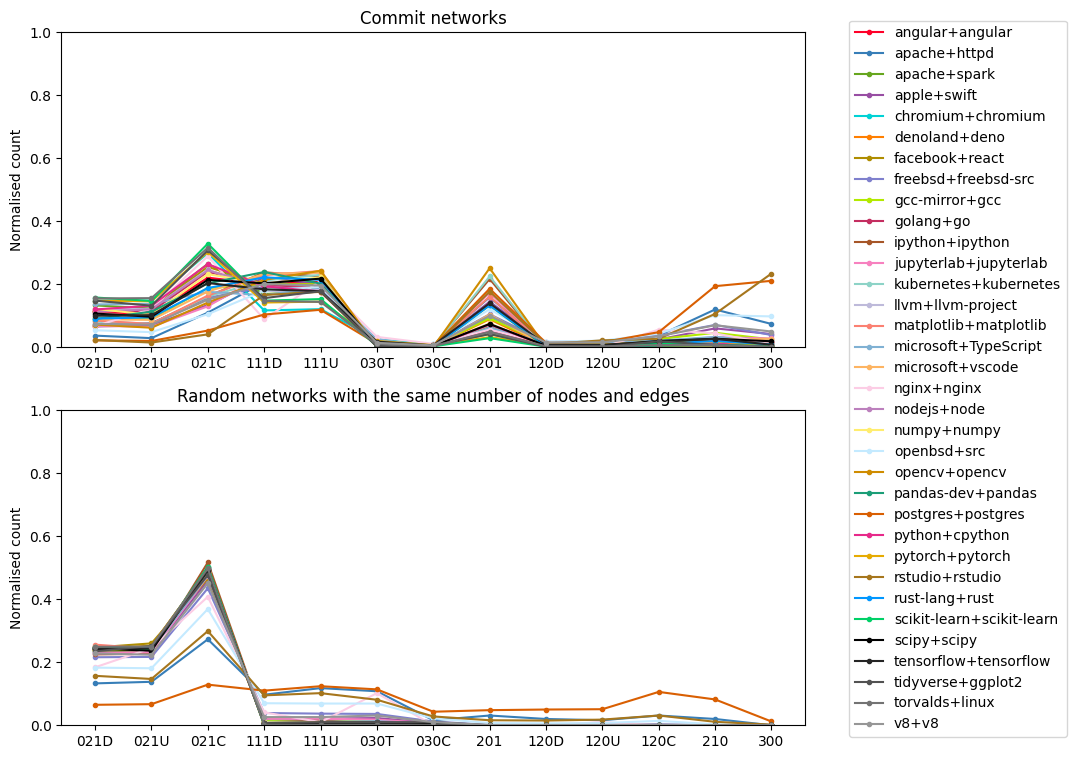

In [28]:
# Create a vertically split plot canvas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))

# Defines a set of colours to represent each repository/random network
cols = ["#ff0029", "#377eb8", "#66a61e", "#984ea3", "#00d2d5", "#ff7f00", "#af8d00", "#7f80cd", "#b3e900", "#c42e60", "#a65628", "#f781bf", "#8dd3c7", "#bebada", "#fb8072", "#80b1d3", "#fdb462", "#fccde5", "#bc80bd", "#ffed6f", "#c4eaff", "#cf8c00", "#1b9e77", "#d95f02", "#e7298a", "#e6ab02", "#a6761d", "#0097ff", "#00d067", "#000000", "#252525", "#525252", "#737373", "#969696", "#bdbdbd", "#f43600", "#4ba93b", "#5779bb", "#927acc", "#97ee3f", "#bf3947", "#9f5b00", "#f48758", "#8caed6", "#f2b94f", "#eff26e", "#e43872", "#d9b100", "#9d7a00", "#698cff", "#d9d9d9", "#00d27e", "#d06800", "#009f82", "#c49200", "#cbe8ff", "#fecddf", "#c27eb6", "#8cd2ce", "#c4b8d9", "#f883b0", "#a49100", "#f48800", "#27d0df", "#a04a9b"]

# Loop over the normalised triadic censuses for each commit network and plot these on top of one another in the top subplot
i=0
for repository, triad_data in normalised_triadic_censuses.items():
    triads = triad_data.keys()
    normalised_counts = triad_data.values()
    ax1.plot(triads, normalised_counts, label=repository, marker=".", color=cols[i])
    i+=1

ax1.set_ylim([0, 1.0])
ax1.set_ylabel("Normalised count")
ax1.set_title("Commit networks")

# Compress the sub-plot to enable a legend to be added
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Add a legend
ax1.legend(loc='center left', bbox_to_anchor=(1.05, -0.1))

# Repeat the above for the random networks, plotting the normalised triadic censuses in the bottom sub-plot
i=0
for repository, triad_data in normalised_triadic_censuses_for_random_networks.items():
    triads = triad_data.keys()
    normalised_counts = triad_data.values()
    ax2.plot(triads, normalised_counts, label=repository, marker=".", color=cols[i])
    i+=1
    
ax2.set_ylim([0, 1.0])
ax2.set_ylabel("Normalised count")
ax2.set_title("Random networks with the same number of nodes and edges")
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])


plt.show()



#### Summary of observations

- The profile of the normalised triadic census is arguably distinct with some types of triads being scarce across all networks (e.g., $030T$, $030C$, $120D$, $120U$) and others more abundant (e.g., $021C$, $111U$, $201$);
- However there is some variance between the commit networks for some triad types (e.g., $021C$, $210$, $300$).
- The profiles between the commit networks and the random networks are arguably different overall, with some notable differences in triad types (e.g., $111D$, $111U$, $030T$, $300$);
- However, there are some similarities in individual triad types being abundant or scarce (e.g., $021D$, $021U$, $021C$).

<br/>

- In summary, the results provide some evidence that despite the notable differences seen in the normalised global network measures (e.g., reciprocity, transitivity, etc.), the differences are arguably reduced when considering the distribution of triadic 'building blocks' across the networks and the commit networks could be considered as being structurally similar from this perspective.

- However, this only provides a preliminary analysis and statistical robustness should be considered if this analysis is taken further (See Extra:).

> **Extra**:  Statistical robustness
>
> To improve the evidence base for the analysis conducted, i.e., confidently determine the similarity of the commit networks in terms of triad abundance (network motifs) and scarcity (network anti-motifs), and whether commit networks are a 'superfamily' of complex networks or part of another, the following considerations should be made in any subsequent analysis:  
> 
> - Using an ensemble of (i.e., multiple) random networks, rather than just a single example;
> - Using additional 'Null models' for generating the random networks, rather than just the same number of nodes and edges;
> - Incorporating formulas for determining whether the abundance and sparsity of particular triads are significantly different to that of random networks, rather than only by human interpretation of a plot of the distribution.
> 
> **Optional Extra**: Information on how to do the above can be found in the following (repeated from the Extra: cells earlier in this section of the Notebook):
>> Milo, R., Itzkovitz, S., Kashtan, N., Levitt, R., Shen-Orr, S., Ayzenshtat, I., ... & Alon, U. (2004). Superfamilies of evolved and designed networks. Science, 303(5663), 1538-1542.
>. http://stat.asu.edu/~dieter/courses/APM_598/Alon_science.pdf
>
> **Optional Extra**: Network 'Motifs' based on the abundance and scarcity of building blocks can also be seen for networks with a temporal dimension. 
>> Temporal motifs: https://snap.stanford.edu/temporal-motifs/

<br>
<br>

---

<br>
<br>


## 3. Considering commit behaviour within repositories

Analyst interest in the decomposition and comparison of commit behaviour could be focused on individual repositories rather than across them. Next we will explore two example questions we *could ask* about the commit data. Starting with a particular, example repository and then expanding to analysis of each repository.



### 3.1 Is commit behaviour similar over time?

The commit data has timestamps which allows us to create networks for different subsets of commits that span different time periods. From this we can investigate whether the observed network structure is similar from month to month, or how the network structure grows and evolves over the course of the year. Here we will focus on the later, but the former is explored in the "Extra" section at the end of the notebook.

#### Network Building

We currently have directed networks that represent the cumulative commit data over 12 months. To provide a basis for comparing aspects of the growth of the network we can create another network that only contains behaviour from the beginning of the time period the data represents.

Lets define a new Python method that will be an extended version of the commitsToNetwork(..) method defined earlier in Section 1 of this notebook. We will then use this to create a network containing the commits for the month of January only.

In [29]:
# Code comment in the method below are limited to notable differences/additions from 
# the previous commitsToNetwork(..) method.

def commitsToNetworkWithDateCutoff(fn, maxDate):   # this method has an extra parameter, the maximum (latest) commit timestamp to consider
    H = nx.DiGraph()
    
    with open(fn) as csvfile:
        reader = csv.reader(csvfile)
        
        user_of_the_next_commit = next(reader)[0] 
        
        for i, commit in enumerate(reader):
            user_of_this_commit = commit[0]
            
            # NEW ADDITION
            timestamp = commit[1]                                                       # extract the commit timestamp string
            dt_timestamp = datetime.strptime(timestamp, "%d/%m/%Y %H:%M:%S %z")         # convert it to a Python datetime object
            if dt_timestamp >= maxDate:                                                 # if the commit timestamp is later than the maximum timestamp
                user_of_the_next_commit = user_of_this_commit                           # don't add the commit to the network and move on to the next commit
                continue
            
            if H.has_edge(user_of_the_next_commit, user_of_this_commit):
                H[user_of_the_next_commit][user_of_this_commit]["weight"] += 1
            else:
                H.add_edge(user_of_the_next_commit, user_of_this_commit, weight=1)

            user_of_the_next_commit = user_of_this_commit
            
    H.remove_edges_from(nx.selfloop_edges(H))

    return H


# Using the jupyterlab commit data as our example network
fn = "data/jupyterlab+jupyterlab.csv"

# Create a Python datetime object set as the 1st February
maxDate = datetime(2020, 2, 1, tzinfo=timezone.utc)

# Create a directed network of the JupyterLab data up to this maximum date (i.e., create a network for only the January Commits)
J = commitsToNetworkWithDateCutoff(fn, maxDate)

In [30]:
print(f"Number of nodes: {J.number_of_nodes()}")
print(f"Number of edges: {J.number_of_edges()}")
print(f"Total of edge weights: {J.size(weight='weight')}")

Number of nodes: 28
Number of edges: 89
Total of edge weights: 177.0


The resulting January network has less edge weights as expected, but also less users than the network spanning 12 months (28 vs 126) and less edges between users (89 vs 677). Lets visualise the two networks before comparing the structures through network measures.


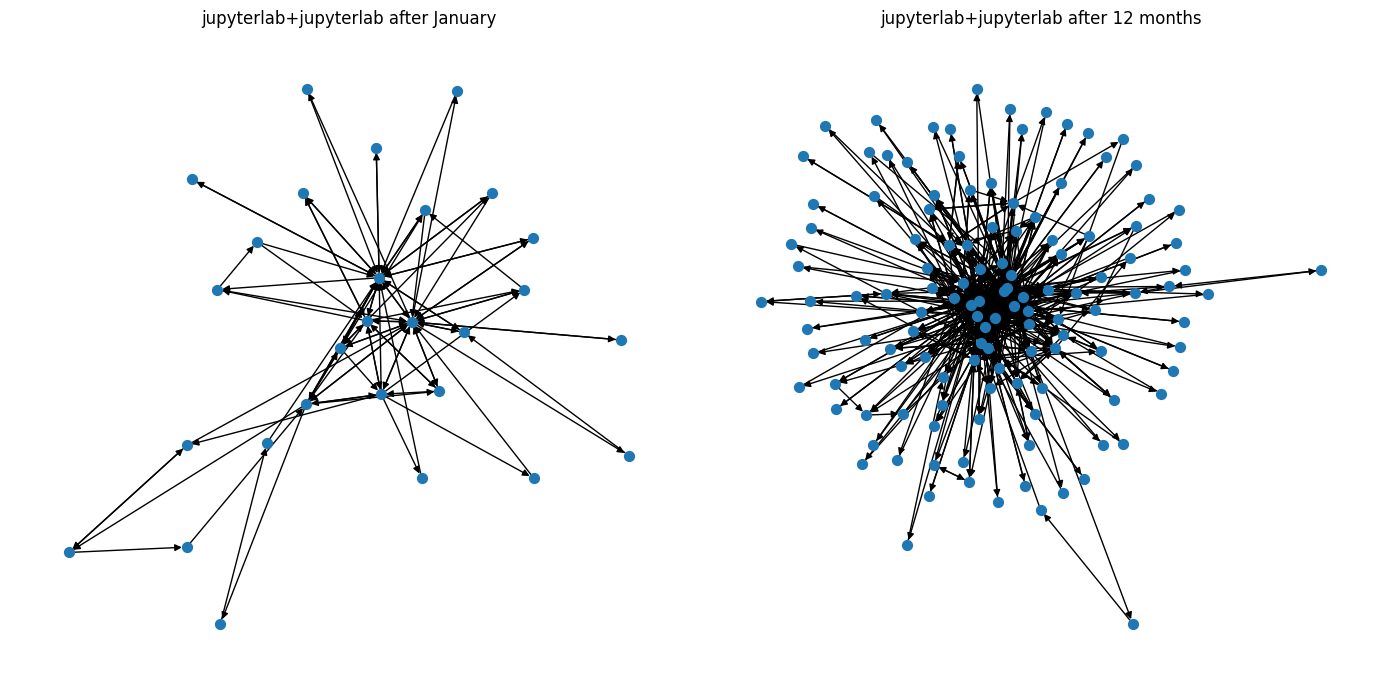

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
nx.draw(J, ax=ax1, node_size=50)
nx.draw(G, ax=ax2, node_size=50)
ax1.set_title("jupyterlab+jupyterlab after January")
ax2.set_title("jupyterlab+jupyterlab after 12 months")
plt.tight_layout()
plt.show()

#### Triadic Census

Lets calculate the (normalised) triadic census for the January network and plot this against the 12-month network in a similar comparison to the task of comparing across networks of different repositories.

In [32]:
# Calculate the triadic census for J using the calculate_normalised_connected_triadic_census(..) 
# method defined earlier and assign the result as J_census. Extract the 12-month network from the 
# existing normalised_triadic_censuses dictionary into a convenience variable, G_census.

J_census = calculate_normalised_connected_triadic_census(J)
G_census = normalised_triadic_censuses["jupyterlab+jupyterlab"]

# Plot the two censuses


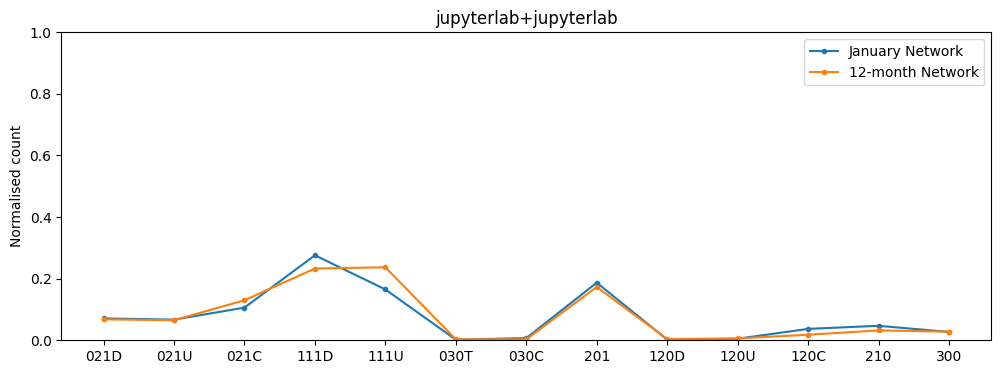

In [33]:
# Plot the two censuses

fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the January and 12-month network on top of one another to allow a comparison
# on a per-triad basis as well as the overall distribution
ax1.plot(J_census.keys(), J_census.values(), label="January Network", marker=".")
ax1.plot(G_census.keys(), G_census.values(), label="12-month Network", marker=".")

ax1.set_ylim([0, 1.0])
ax1.set_ylabel("Normalised count")
ax1.set_title("jupyterlab+jupyterlab")

# Add a legend
ax1.legend(loc='upper right')

plt.show()


<br/>

Some observations:

- The networks have very similar distributions;
- With some minor differences for $111D$ and $111U$;
- This suggests that the networks are built up by the same 'building blocks', despite representing different time periods, users, and commits.
- This also extends to the size-independent, global network measures also used earlier:

In [34]:
print(f"Density of J: {nx.density(J):.2f}\n"  # calculate the density of each network
      f"Density of G: {nx.density(G):.2f}\n"
)
print(f"Reciprocity of J: {nx.reciprocity(J):.2f}\n"  # calculate the overall reciprocity of each network
      f"Reciprocity of G: {nx.reciprocity(G):.2f}\n"
)
print(f"Avg. Clustering of J: {nx.average_clustering(J):.2f}\n"  # calculate the average (local) clustering of each network
      f"Avg. Clustering of G: {nx.average_clustering(G):.2f}\n"
)
print(f"Transitivity of J: {nx.transitivity(J):.2f}\n"  # calculate the transitivity of each network
      f"Transitivity of G: {nx.transitivity(G):.2f}\n"
)


Density of J: 0.12
Density of G: 0.04

Reciprocity of J: 0.58
Reciprocity of G: 0.58

Avg. Clustering of J: 0.53
Avg. Clustering of G: 0.58

Transitivity of J: 0.27
Transitivity of G: 0.23



<br>
<br>

#### Triadic Closure

As another temporally-driven example analyst task, lets examine whether the social phenomenon 'Triadic Closure' occurs over time for the example network.

> Triadic closure was first proposed by sociologist Georg Simmel, and can be defined as: given 3 nodes in a (social) network (e.g. with ids A, B, C), if a connection exists between A + B, and B + C, then over time there is a strong likelihood that a connection between A + C will form. 

We've seen in previous notebooks that "small-world" social networks typically have high (local) clustering where a nodes friends are often friends themselves. This is an extension of that concept to consider this in a more dynamic network perspective.

Here we will use transitivity as an example network measure for triadic closure.

> Recap: NetworkX's transitivity method https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.transitivity.html

In [35]:
print(f"Transitivity of J: {nx.transitivity(J):.2f}\n"  # Calculate the transitivity of the January Network
      f"Transitivity of G: {nx.transitivity(G):.2f}\n"  # Calculate the transitivity of the complete Network
)

Transitivity of J: 0.27
Transitivity of G: 0.23



<br>

The results does not support for triadic closure over time in the network.

However, this analysis is arguably biased as there are a different number of nodes in J and G. It could be that the users that arrive and commit after January have less transitivity than those that are present and commit in the first month.

<br>
<br>


To address this, lets repeat the analysis but only calculate the transitivity for the same users that appear in both J and G.

In [103]:
print(f"Transitivity of J: {nx.transitivity(J):.2f}\n" 
      f"Transitivity in a subgraph of G with the same nodes as J: {nx.transitivity(G.subgraph(J.nodes())):.2f}\n" #Create an (induced) subgraph of G that only contains the users in J.
)

Transitivity of J: 0.27
Transitivity in a subgraph of G with the same nodes as J: 0.51



<br> 

In this case there is evidence for triadic closure for those nodes in J between January and December.

<br>
<br>

To check whether this is common characteristic of the commit networks, or just for JupyterLab, lets repeat the triadic closure analysis for each repository:

In [36]:

for repository, network in commitNetworks.items():
    
    # Reconstruct the file location from the repository name, then build a January network for the repository 
    # using the commitsToNetworkWithDateCutoff(..) method defined earlier
    J = commitsToNetworkWithDateCutoff("data/"+repository+".csv", maxDate)      
    
    # Extract an (induced) subgraph of the repository's 12-month network to only include the nodes that are
    # also in the January network, J.
    G_with_only_J_nodes = network.subgraph(J.nodes())
    
    # Calculate the difference in transitivity from the January network to the 12-month network
    print(f"Repository: {repository} \n"
          f"Transitivity difference: {(nx.transitivity(G_with_only_J_nodes) - nx.transitivity(J)):.2f}\n"
         )
    

    

Repository: angular+angular 
Transitivity difference: 0.39

Repository: apache+httpd 
Transitivity difference: 0.50

Repository: apache+spark 
Transitivity difference: 0.26

Repository: apple+swift 
Transitivity difference: 0.28

Repository: chromium+chromium 
Transitivity difference: 0.12

Repository: denoland+deno 
Transitivity difference: 0.22

Repository: facebook+react 
Transitivity difference: 0.25

Repository: freebsd+freebsd-src 
Transitivity difference: 0.34

Repository: gcc-mirror+gcc 
Transitivity difference: 0.26

Repository: golang+go 
Transitivity difference: 0.42

Repository: ipython+ipython 
Transitivity difference: 0.00

Repository: jupyterlab+jupyterlab 
Transitivity difference: 0.24

Repository: kubernetes+kubernetes 
Transitivity difference: 0.08

Repository: llvm+llvm-project 
Transitivity difference: 0.19

Repository: matplotlib+matplotlib 
Transitivity difference: 0.20

Repository: microsoft+TypeScript 
Transitivity difference: 0.22

Repository: microsoft+vscode 

<br>
<br>

#### Summary of observations

- We've seen how analysis of triads occurring in commit networks can also reveal similarities between networks built from commit data spanning different time periods.


- We've also seen that triadic closure is common between the GitHub users committing to repositories. 
- However we should be careful about what we conclude from this. We have found some evidence in commit behaviours that *correlates* with what has been seen with triadic closure in social network structures. That does not necessarily mean that GitHub collaboration behaviours mimics exactly how social networks grow over time.


> **Extra**: Repeat the analysis in the cell above to use the  average (local) clustering coefficient instead of transitivity and observe the extent that triadic closure occurs.

<br>

<br>
<br>


### 3.2 Are 'similar' users connected to each other?

So far we've largely focused on the structural characteristics of networks built from commit data from the perspective of sets of (3) nodes. We've seen how structural similarity between and within repositories can be seen through some, but not all network measures, despite differences in the number of users, edges, commits between the repositories.

We will move on with our investigations to examine whether the manner in which nodes (GitHub users) in the networks are connected together correlates with different node-to-node similarity phenomena seen in social and other complex networks more generally.




Firstly, a common characteristic of social networks is that there are 'hub' nodes with lots of connections. In undirected friendship social networks, this could be nodes that are very friendly and popular. In directed social networks, such as online communities like Twitter, Twitch, etc., this could be nodes with lots of 'in' edges (e.g., lots of followers). 

In social networks, 'hubs' tend to have ties to other 'hubs', for example, lots of people know celebrities, but celebrities tend to know each other more than everyone that knows of them.  This phenomenon doesn't occur in all types of real-world complex networks, for example in networks built to represent the protein interaction map of yeast, hubs typically avoid hubs.

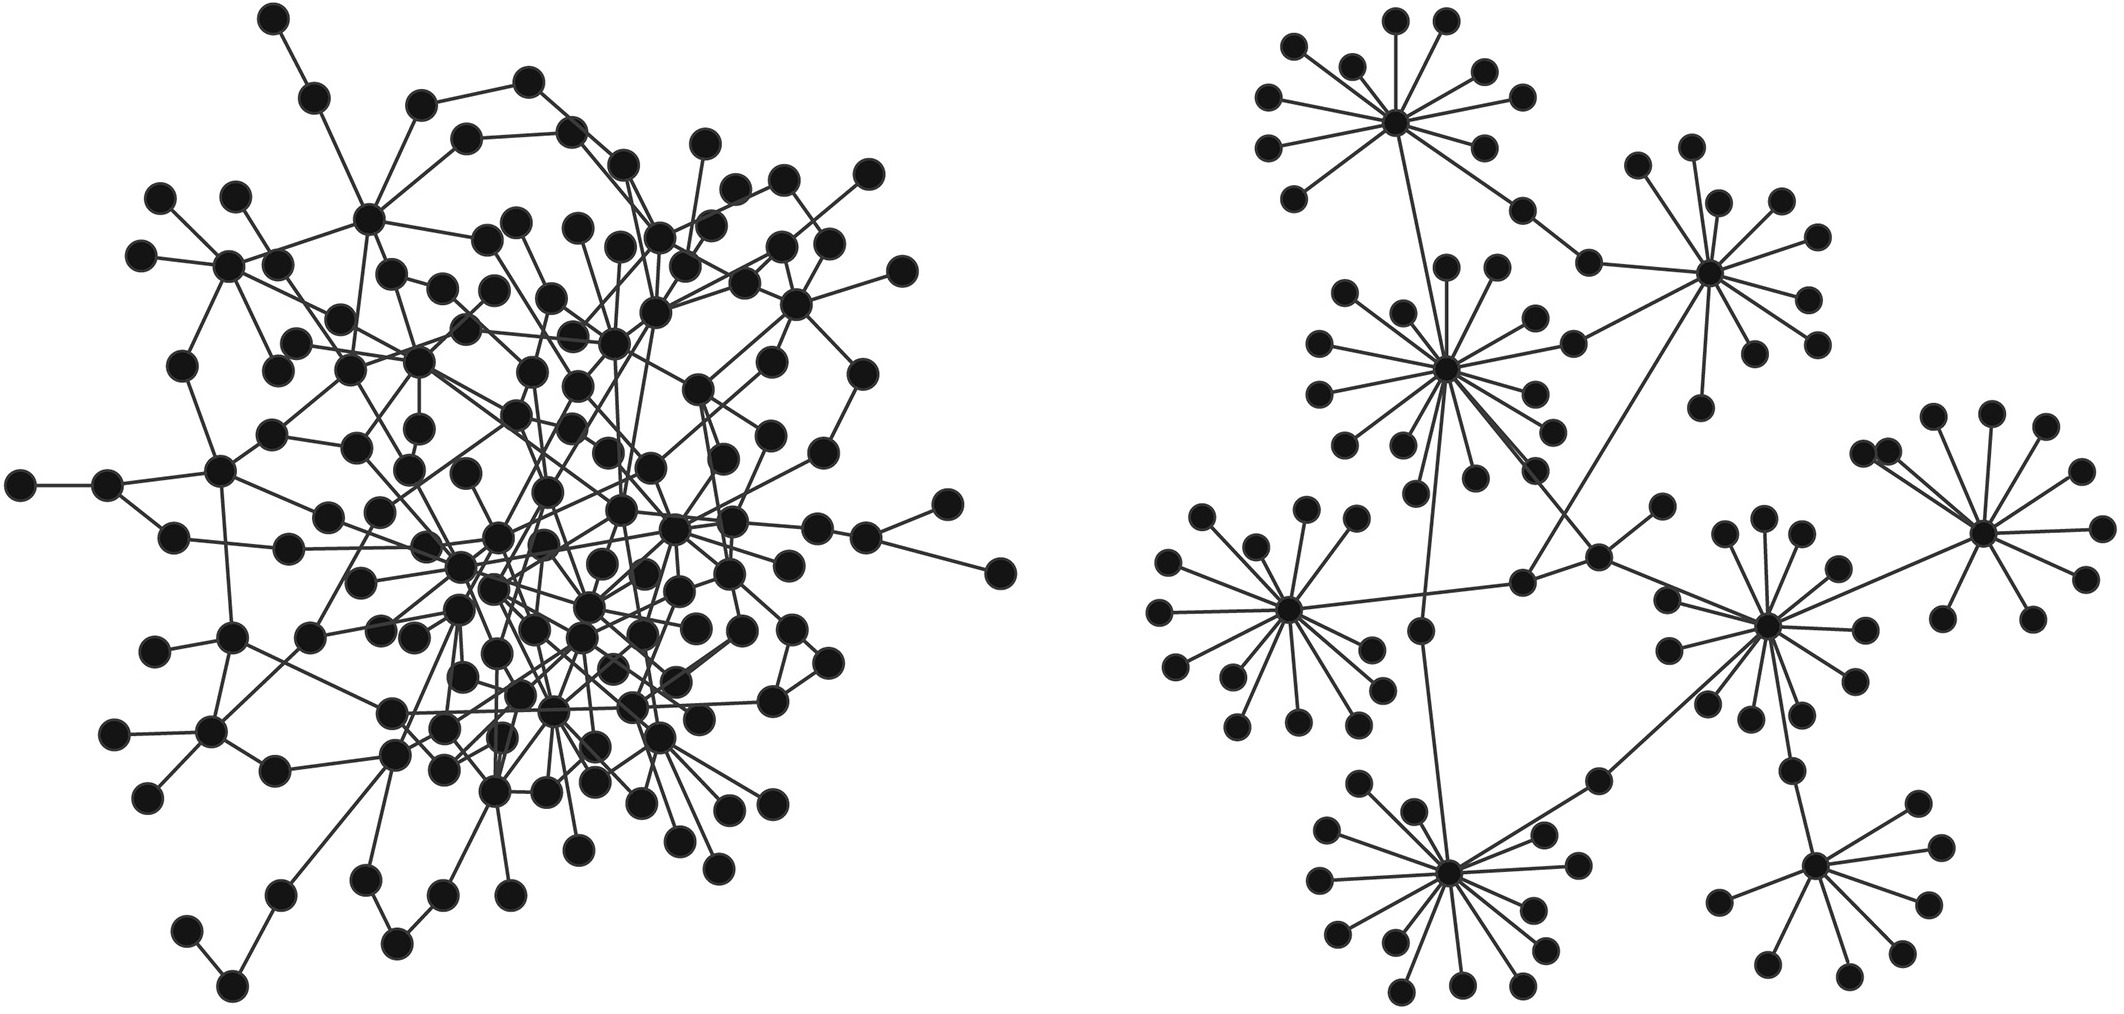

The commit networks are arguably interesting to explore in this regard as they about collaborative connections between people but not necessarily in a communication 'social' sense that drives social media.





Secondly, another phenomena that occurs in social behaviour is the concept of "homophily", where 'similar' people tend to connect together and can even have similar lifestyles (see Extra, below). We see this in the typical human nature of forming groups based on shared interests, in both online and offline communities.  

From a network perspective, both of these can be investigated through the concept of "assortativity" or "disassortativity". NetworkX provides several API methods depending on what type of data the attributes of nodes are representing:

https://networkx.org/documentation/stable/reference/algorithms/assortativity.html





> **Optional Extra**: Homophily in what venues people visit using Location Based Social Network data. Chorley, M. J., Whitaker, R. M., & Allen, S. M. (2015). Personality and location-based social networks. Computers in Human Behavior, 46, 45-56. https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.667.7234



<br>
<br>


#### An introductory look at the connectivity between 'hubs'



##### Extra: Exploring the nodes with the largest degrees: 
Lets begin by examining the largest in+out degrees in each 12-month commit network and whether these are concentrated on a single 'hub' user or multiple users.

In [37]:
# For each network, calculate the (in+out) degree sequence and then sort this from largest (in+out) degree to smallest.
# Refer back to the Reddit notebook for more information on node degrees for directed networks.

for name, network in commitNetworks.items():
    degree_sequence = sorted(network.degree(), reverse=True, key=operator.itemgetter(1))
    print(name)
    print(degree_sequence[0:3]) # print the 3 nodes with the largest degree [('the user/node id', in+out degree), ...]
    print()
    

angular+angular
[('39755', 137), ('39762', 135), ('39523', 105)]

apache+httpd
[('33307', 28), ('33237', 25), ('33303', 19)]

apache+spark
[('398401', 135), ('398429', 127), ('397645', 118)]

apple+swift
[('29455', 331), ('29427', 191), ('109924', 189)]

chromium+chromium
[('395572', 3147), ('395573', 1629), ('404772', 1130)]

denoland+deno
[('124655', 211), ('124654', 129), ('123598', 109)]

facebook+react
[('184564', 89), ('184541', 76), ('184517', 66)]

freebsd+freebsd-src
[('183472', 162), ('183482', 161), ('183453', 158)]

gcc-mirror+gcc
[('188515', 223), ('133386', 219), ('133416', 187)]

golang+go
[('122285', 181), ('133000', 116), ('121815', 113)]

ipython+ipython
[('281349', 99), ('281273', 13), ('280940', 12)]

jupyterlab+jupyterlab
[('118188', 107), ('118118', 82), ('118077', 74)]

kubernetes+kubernetes
[('13687', 1039), ('13618', 162), ('13638', 101)]

llvm+llvm-project
[('109734', 818), ('109854', 623), ('109896', 552)]

matplotlib+matplotlib
[('114594', 155), ('174584', 1

<br>
<br>

From the above we can see that some networks have a single user with a notably large in+out degree and others have multiple users with similar, large in+out degrees (relative to the degree distribution in the individual network.

This leads to the question of whether these largely connected users are connected together themselves, or do they represent 'hubs' in different parts of the network?

One option to examine this is to explore and compare the sets of users these largely connected nodes are connected to. NetworkX provides methods for extracting this on a per-node basis:

```python
G.neighbors(u)     # In NetworkX DiGraphs, this is the set of nodes that u has an edge to  (i.e., the nodes that make up u's 'out' degree())
G.successors(u)    # In NetworkX DiGraphs, this is also the set of nodes that u has an edge to  (i.e., the nodes that make up u's 'out' degree())
G.predecessors(u)  # In NetworkX DiGraphs, this is the set of nodes that have an edge going to u (i.e., the nodes that make up u's 'in' degree())
```

https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.neighbors.html
https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.successors.html
https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.predecessors.html

<br/>

As an example, lets examine the two users with the largest in+out degree for an example commit network.

In [38]:
# Assign the commit network to a convenience variable, H
H = commitNetworks["nginx+nginx"]

# Calculate the in+out degree sequence and then sort this from largest degree to smallest, print the largest 3 nodes
degree_sequence = sorted(H.degree(), reverse=True, key=operator.itemgetter(1))
print("Three nodes with the largest in+out degree:", dict(degree_sequence[:3]))

# Extract out the node ids for the nodes with the largest and second largest in+out degree
node_with_largest_degree = degree_sequence[0][0]
node_with_second_largest_degree = degree_sequence[1][0]

# For the node with the largest in+out degree, extract out its 'neighbors', successors, predecessors and the nodes 
# that are either a successor or a predecessor, as a second interpretation of 'neighbors'. Print these sets.
ld_neighbors = set(H.neighbors(node_with_largest_degree))
ld_successors = set(H.successors(node_with_largest_degree))
ld_predecessors = set(H.predecessors(node_with_largest_degree))
ld_neighbors2 = ld_successors.union(ld_predecessors)

print(f"\n{node_with_largest_degree}'s 'neighbors':                {(', '.join(ld_neighbors))}")
print(f"{node_with_largest_degree}'s neighbours on 'out' edges:  {(', '.join(ld_successors))}")
print(f"{node_with_largest_degree}'s neighbours on 'in' edges:   {(', '.join(ld_predecessors))}")
print(f"{node_with_largest_degree}'s neighbours on all edges:    {(', '.join(ld_neighbors2))}")

# Repeat the above for the node with the second largest in+out degree
sld_neighbors = set(H.neighbors(node_with_second_largest_degree))
sld_successors = set(H.successors(node_with_second_largest_degree))
sld_predecessors = set(H.predecessors(node_with_second_largest_degree))
sld_neighbors2 = sld_successors.union(sld_predecessors)

print(f"\n{node_with_second_largest_degree}'s 'neighbors':                {(', '.join(sld_neighbors))}")
print(f"{node_with_second_largest_degree}'s neighbours on 'out' edges:  {(', '.join(sld_successors))}")
print(f"{node_with_second_largest_degree}'s neighbours on 'in' edges:   {(', '.join(sld_predecessors))}")
print(f"{node_with_second_largest_degree}'s neighbours on all edges:    {(', '.join(sld_neighbors2))}")

# Print the nodes that are successors, predecessors, and neighbors for both nodes to help with the comparison.

print(f"\nShared neighours (all edges):       {(', '.join(ld_neighbors2.intersection(sld_neighbors2)))}")
print(f"Shared neighbours on 'out' edges:   {(', '.join(ld_successors.intersection(sld_successors)))}")
print(f"Shared neighbours on 'in' edges:    {(', '.join(ld_predecessors.intersection(sld_predecessors)))}")



Three nodes with the largest in+out degree: {'281484': 14, '281475': 10, '281482': 9}

281484's 'neighbors':                281419, 281468, 281441, 281446, 281482, 281485, 281475, 281473
281484's neighbours on 'out' edges:  281419, 281468, 281441, 281446, 281482, 281485, 281475, 281473
281484's neighbours on 'in' edges:   281468, 281446, 281485, 281482, 281475, 281395
281484's neighbours on all edges:    281419, 281468, 281441, 281446, 281482, 281485, 281475, 281473, 281395

281475's 'neighbors':                281436, 281484, 281458, 281468
281475's neighbours on 'out' edges:  281436, 281484, 281458, 281468
281475's neighbours on 'in' edges:   281468, 281441, 281484, 281482, 281473, 281395
281475's neighbours on all edges:    281468, 281441, 281484, 281458, 281482, 281436, 281473, 281395

Shared neighours (all edges):       281468, 281441, 281482, 281473, 281395
Shared neighbours on 'out' edges:   281468
Shared neighbours on 'in' edges:    281482, 281395, 281468


Some observations:

- The two nodes with the largest in+out degrees have mutual edges between them;
- They also share some common neighbours, mostly through 'in edges', but not all;
- This provides some initial evidence that the 'hubs tend to have ties to other hubs' phenomenon may also apply to the commit networks.


<br>
<br>


#### Are users with similar degree connected?

To examine this at scale, the analysis can be generalised into measuring the 'assortativity' of the network - specifically the degree assortativity.

> Assortativity measures the similarity of connections in the graph with respect to the node degree - NetworkX documentation.

```python
nx.degree_assortativity_coefficient(..)
```

The degree assortativity coefficient will be calculated as a value between -1 and +1. Where -1 suggests that the network is strongly disassortative (strong negative correlation between a node's degree and being connected, i.e., the hubs avoid each other, linking instead to small-degree nodes), +1 suggests that the network is strongly assortative (strong positive correlation between a node's degree and being connected together, i.e., hubs link to each other and avoid linking to small-degree nodes) and 0 suggests that the network has 'neutral' mixing.

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html

Lets calculate the degree assortativity coefficient for each (12-month) commit network and examine the descriptive statistics across them:

In [39]:
assortativity_per_commit_network = []

for repository, network in commitNetworks.items():                       # for each repository and 12-month commit network
    deg_assortativity = nx.degree_assortativity_coefficient(network)     # calculate the degree assortativity
    assortativity_per_commit_network.append(deg_assortativity)           # add it to a list for calculating descriptive statistics across
    print(f"Repository: {repository}\n"
          f"Degree Assortativity: {deg_assortativity:.2f}\n"             # and print out the value for the specific repository
         )

Repository: angular+angular
Degree Assortativity: -0.27

Repository: apache+httpd
Degree Assortativity: -0.28

Repository: apache+spark
Degree Assortativity: -0.26

Repository: apple+swift
Degree Assortativity: -0.38

Repository: chromium+chromium
Degree Assortativity: -0.11

Repository: denoland+deno
Degree Assortativity: -0.31

Repository: facebook+react
Degree Assortativity: -0.48

Repository: freebsd+freebsd-src
Degree Assortativity: -0.25

Repository: gcc-mirror+gcc
Degree Assortativity: -0.30

Repository: golang+go
Degree Assortativity: -0.27

Repository: ipython+ipython
Degree Assortativity: -0.41

Repository: jupyterlab+jupyterlab
Degree Assortativity: -0.41

Repository: kubernetes+kubernetes
Degree Assortativity: -0.20

Repository: llvm+llvm-project
Degree Assortativity: -0.22

Repository: matplotlib+matplotlib
Degree Assortativity: -0.55

Repository: microsoft+TypeScript
Degree Assortativity: -0.30

Repository: microsoft+vscode
Degree Assortativity: -0.53

Repository: nginx+n

In [40]:
print("\nDescriptive Statistics:\n")
print(f"Mean degree assortativity: {np.mean(assortativity_per_commit_network):.2f}")
print(f"Std. Deviation: {np.std(assortativity_per_commit_network):.2f}\n")

print(f"Smallest degree assortativity: {np.amin(assortativity_per_commit_network):.2f}")
print(f"Largest degree assortativity: {np.amax(assortativity_per_commit_network):.2f}\n")
      
print(f"Median degree assortativity: {np.median(assortativity_per_commit_network):.2f}")



Descriptive Statistics:

Mean degree assortativity: -0.31
Std. Deviation: 0.11

Smallest degree assortativity: -0.55
Largest degree assortativity: -0.10

Median degree assortativity: -0.30


<br>
<br>

Observations:

- The results indicate that, contrary to the expectation from looking at the 2 nodes with the largest in+out degree in the example network, the networks typically have  moderate disassortative mixing or weak-disassortative-to-neutral mixing. 

> **Extra**: The default NetworkX implementation of the degree_assortativity_coefficient(..) method compares the 'in' degree of source nodes with the 'out' degree of target nodes. Repeat the analysis above with different edge type combinations. Refer to the documentation page for the arguments to pass to the method to achieve this.

- However, as the network is a simple network where only one 'in edge' and 'out edge' can exist between nodes, the results may suffer from biasing effects such as "structural cutoffs". This consideration goes beyond the scope of this notebook, but more information can be found in optional, extended reading here:
> **Optional Extra**: Structural Cutoffs http://networksciencebook.com/chapter/7#structural-cutoffs

- Overall, **is this surprising given the dynamics of GitHub commits? Would we expect that users consciously wait to commit after other, particular users?**

<br>
<br>

#### Are users in the same timezone typically connected?

Another potentially correlating factor in the commit behaviour of nodes could be when during the day the commits happen. Lets investigate whether users committing from the same timezone are more likely to 'mix' than with other timezones. We will use an alternative NetworkX method for this, which will calculate the assortativity coefficient on a node attribute, rather than its degree:

```python
nx.attribute_assortativity_coefficient(..)
```
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html

<br/>

Before we do this analysis we first have to determine and add a timezone attribute to the nodes. For simplicity at first, lets assume for now that users have a single, typical timezone and that this is the timezone of their last commit (i.e., first commit that appears in the time reverse sorted data). 

Lets define a new Python method that will be an extended version of the commitsToNetwork(..) method defined earlier in Section 1 of this notebook. 


In [42]:
# Code comment in the method below are limited to notable differences/additions from 
# the previous commitsToNetwork(..) method.

def commitsToNetworkWithTimezone(fn):
    G = nx.DiGraph()
    
    # Create a Python dictionary to temporarily hold the map between node ids and a timezone value
    timezones = {}
    with open(fn) as csvfile:
        reader = csv.reader(csvfile)
        
        user_of_the_next_commit = next(reader)[0]
                
        for i, commit in enumerate(reader):
            user_of_this_commit = commit[0]
            
            if G.has_edge(user_of_the_next_commit, user_of_this_commit):
                G[user_of_the_next_commit][user_of_this_commit]["weight"] += 1
            else:
                G.add_edge(user_of_the_next_commit, user_of_this_commit, weight=1)
                
            # Assume for simplicity for now that the last timezone a user is in is their timezone.
            # Using the timestamp column of the commit, split the string by blank spaces and then take the 
            # last list item (e.g., "31/12/2020 13:35:52 +0100" becomes ["31/12/2020", "13:35:52", "+0100"]
            #                        becomes "+0100")
            if not user_of_this_commit in timezones:
                timezones[user_of_this_commit] = commit[1].split(" ")[-1]  
                
            user_of_the_next_commit = user_of_this_commit
    
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # Once the network is built and pruned of self-loops, add an attribute named "tz" to each node where
    # the value is the extracted timezone of their last commit, taken from the populated Python dictionary "timezones"
    nx.set_node_attributes(G, timezones, "tz")
    return G




commitNetworksWithTimezone = {} # create the Python dictionary to hold our network objects

for filename in glob.glob("data/*.csv"): # for each csv file in the folder "data" (assumes that "data" is in the same directory as this notebook)
    
    repo = filename[5:-4] # this implementation is simple but inflexible to changes in the filepath for the files. You could replace this with something more
    
    commitNetworksWithTimezone[repo] = commitsToNetworkWithTimezone(filename)

In [43]:
tz_assortativity_per_commit_network = []

for repository, network in commitNetworksWithTimezone.items():                                # for each repository and 12-month commit network
    tz_assortativity = nx.attribute_assortativity_coefficient(network, "tz")                  # calculate the timezone assortativity
    tz_assortativity_per_commit_network.append(tz_assortativity)                              # add it to a list for calculating descriptive statistics across
    
    print(f"Repository: {repository}\n"
          f"Timezone Assortativity: {tz_assortativity:.2f}\n"             # and print out the value for the specific repository
         )
    

Repository: angular+angular
Timezone Assortativity: 0.01

Repository: apache+httpd
Timezone Assortativity: nan

Repository: apache+spark
Timezone Assortativity: -0.03

Repository: apple+swift
Timezone Assortativity: -0.03

Repository: chromium+chromium
Timezone Assortativity: -0.00

Repository: denoland+deno
Timezone Assortativity: -0.02

Repository: facebook+react
Timezone Assortativity: -0.06

Repository: freebsd+freebsd-src
Timezone Assortativity: -0.01

Repository: gcc-mirror+gcc
Timezone Assortativity: 0.02

Repository: golang+go
Timezone Assortativity: -0.02

Repository: ipython+ipython
Timezone Assortativity: -0.13

Repository: jupyterlab+jupyterlab
Timezone Assortativity: -0.01

Repository: kubernetes+kubernetes
Timezone Assortativity: 0.03

Repository: llvm+llvm-project
Timezone Assortativity: 0.06

Repository: matplotlib+matplotlib
Timezone Assortativity: -0.02

Repository: microsoft+TypeScript
Timezone Assortativity: -0.03

Repository: microsoft+vscode
Timezone Assortativity

c:\Users\adama\AppData\Local\Programs\Python\Python314\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)


**The Timezone attribute assortativity cannot be calculated for some repositories as they only contain users with the same timezone - resulting in nan values**

In [44]:
print("\nDescriptive Statistics:\n")

print(f"Number of networks with calculatable timezone assortativity: {np.count_nonzero(~np.isnan(tz_assortativity_per_commit_network))}\n")

print(f"Mean timezone assortativity: {np.nanmean(tz_assortativity_per_commit_network):.2f}")
print(f"Std. Deviation: {np.nanstd(tz_assortativity_per_commit_network):.2f}\n")

print(f"Smallest timezone assortativity: {np.nanmin(tz_assortativity_per_commit_network):.2f}")
print(f"Largest timezone assortativity: {np.nanmax(tz_assortativity_per_commit_network):.2f}\n")
      
print(f"Median timezone assortativity: {np.nanmedian(tz_assortativity_per_commit_network):.2f}")



Descriptive Statistics:

Number of networks with calculatable timezone assortativity: 32

Mean timezone assortativity: -0.01
Std. Deviation: 0.04

Smallest timezone assortativity: -0.13
Largest timezone assortativity: 0.06

Median timezone assortativity: -0.01


<br>
<br>


#### Summary of observations

- The results suggest that the there is also little assortative or disassortative mixing on the basis of the timezone attribute used.



> **Optional Extra**: Consider whether a better label for the typical timezone of a user can be generated and whether this effects the observations and conclusions made.

<br>
<br>

---

<br>
<br>


## 4. Summary and motivations going forward

1. From the analysis, we've seen that despite wide variety in nodes, edges, and global network measures across networks built from the commit data, there are structural similarities between the networks when considering sub-structures (triads) and this extends to comparing networks within repositories that represent different time periods. This observation is similar to what has been found in social and other complex, 'real-world' networks more generally.

2. In comparison to phenomena often seen in social networks, the networks typically have triadic closure between users over time, but the connectivity between users show typical neutral mixing between users with different numbers of connections and timezones.

3. This suggests that the commit behaviour is likely driven by other factors than those that typically correlate in social networks. This is by no means a negative result, and is arguably unsurprising given that commits are not necessary a 'social' action between individuals but an action among individuals. It also highlights that networks of behaviour between people does not necessarily manifest into a structure that is akin to friend or follower social networks.

4. The results motivate further exploration of the networks, but this is beyond the scope of this notebook's main sections. The analysis extends with a demonstration of another means of comparing networks in the Extra section below. You may wish to extend the analysis of these GitHub commit networks further based on the content of other notebooks in the learning resources as well as further reading as part of independent study.

**Along the way we have:**

- Taken a further look at using Python and NetworkX to build different networks from data and then analyse them.

- We've looked at more methods from graph theory that, while applied to specific questions on the GitHub commit data, are generalisable to analysis of other directed networks (e.g., the Reddit Hyperlink networks in previous notebooks).

- Some we may use again in later weeks and the rest we could. Equally there may be more methods introduced in later weeks/notebooks where you can go back and implement in this notebook as an extension of this analysis. Therefore the analysis here should not be considered exhaustive for examining the data.

<br>
<br>

---

<br>
<br>

<br/>

## Extra: Monthly Commits and Graph Edit Distance

Another perspective to examine the commit data is to create networks representing each month and examine how 'stable' the commit behaviour patterns seen on a month-to-month basis.

### Network Building

To examine this, lets create another alternative version of the commitsToNetwork(..) method defined in Section 1 of the notebook. Here we want, for a given repository of commit data, to create 12 networks, one for each month.

In [36]:
# There are multiple ways that this could be achieved. 
# The below splits the method into two sections for simplicity, 
# but it does mean looping over the commit data twice rather than once.

def commitsToNetworksByMonth(fn):
    
    # Create a Python dictionary to store the commit rows for each month
    commits_by_month = {str(month) : [] for month in range(1,13)}
    
    # For row in the csv file containing the commit data for a given repository
    with open(fn) as csvfile:
        reader = csv.reader(csvfile)
        
        # Loop over each commit and extract the timestamp column as a string
        # Convert the timestamp to a Python datetime object
        # Extract out the month as a string (e.g., 1, 2, 3, .. 12)
        # Using the month, add the commit row to the list of commits for the 
        # given month in the dictionary created at the start of the method
        for i, commit in enumerate(reader):
            timestamp = commit[1]
            dt_timestamp = datetime.strptime(timestamp, "%d/%m/%Y %H:%M:%S %z")
            month = str(dt_timestamp.month)
            
            commits_by_month[month].append(commit)
            
    
    # Now that we have grouped the commit data by month, lets loop over the 
    # commits for each month and create a directed network.
    
    # Create a dictionary to hold the directed networks
    G_for_each_month = {}
    
    # For each month, and list of commits
    for month, commits in commits_by_month.items():
        
        # Create a new DiGraph and assign it as the value for the month in the new dictionary created above
        G_for_each_month[month] = nx.DiGraph()

        # Get the user in the first commit in the list
        user_of_the_next_commit = commits[0][0]
        
        # Starting from the next commit, loop over the commits and create the network in the same way as the
        # original commitToNetworks(..) method in Section 1.
        for i, commit in enumerate(commits[1:]):
            user_of_this_commit = commit[0]
                        
            if G_for_each_month[month].has_edge(user_of_the_next_commit, user_of_this_commit):
                G_for_each_month[month][user_of_the_next_commit][user_of_this_commit]["weight"] += 1
            else:
                G_for_each_month[month].add_edge(user_of_the_next_commit, user_of_this_commit, weight=1)

            user_of_the_next_commit = user_of_this_commit
                        
        G_for_each_month[month].remove_edges_from(nx.selfloop_edges(G_for_each_month[month]))

    # Return the dictionary of 12 networks
    return G_for_each_month


# The above network can be used for any and all of the commit data files.
# However, lets continue focusing on JupyterLab as an example case study.
fn = "data/jupyterlab+jupyterlab.csv"
G_Months = commitsToNetworksByMonth(fn)

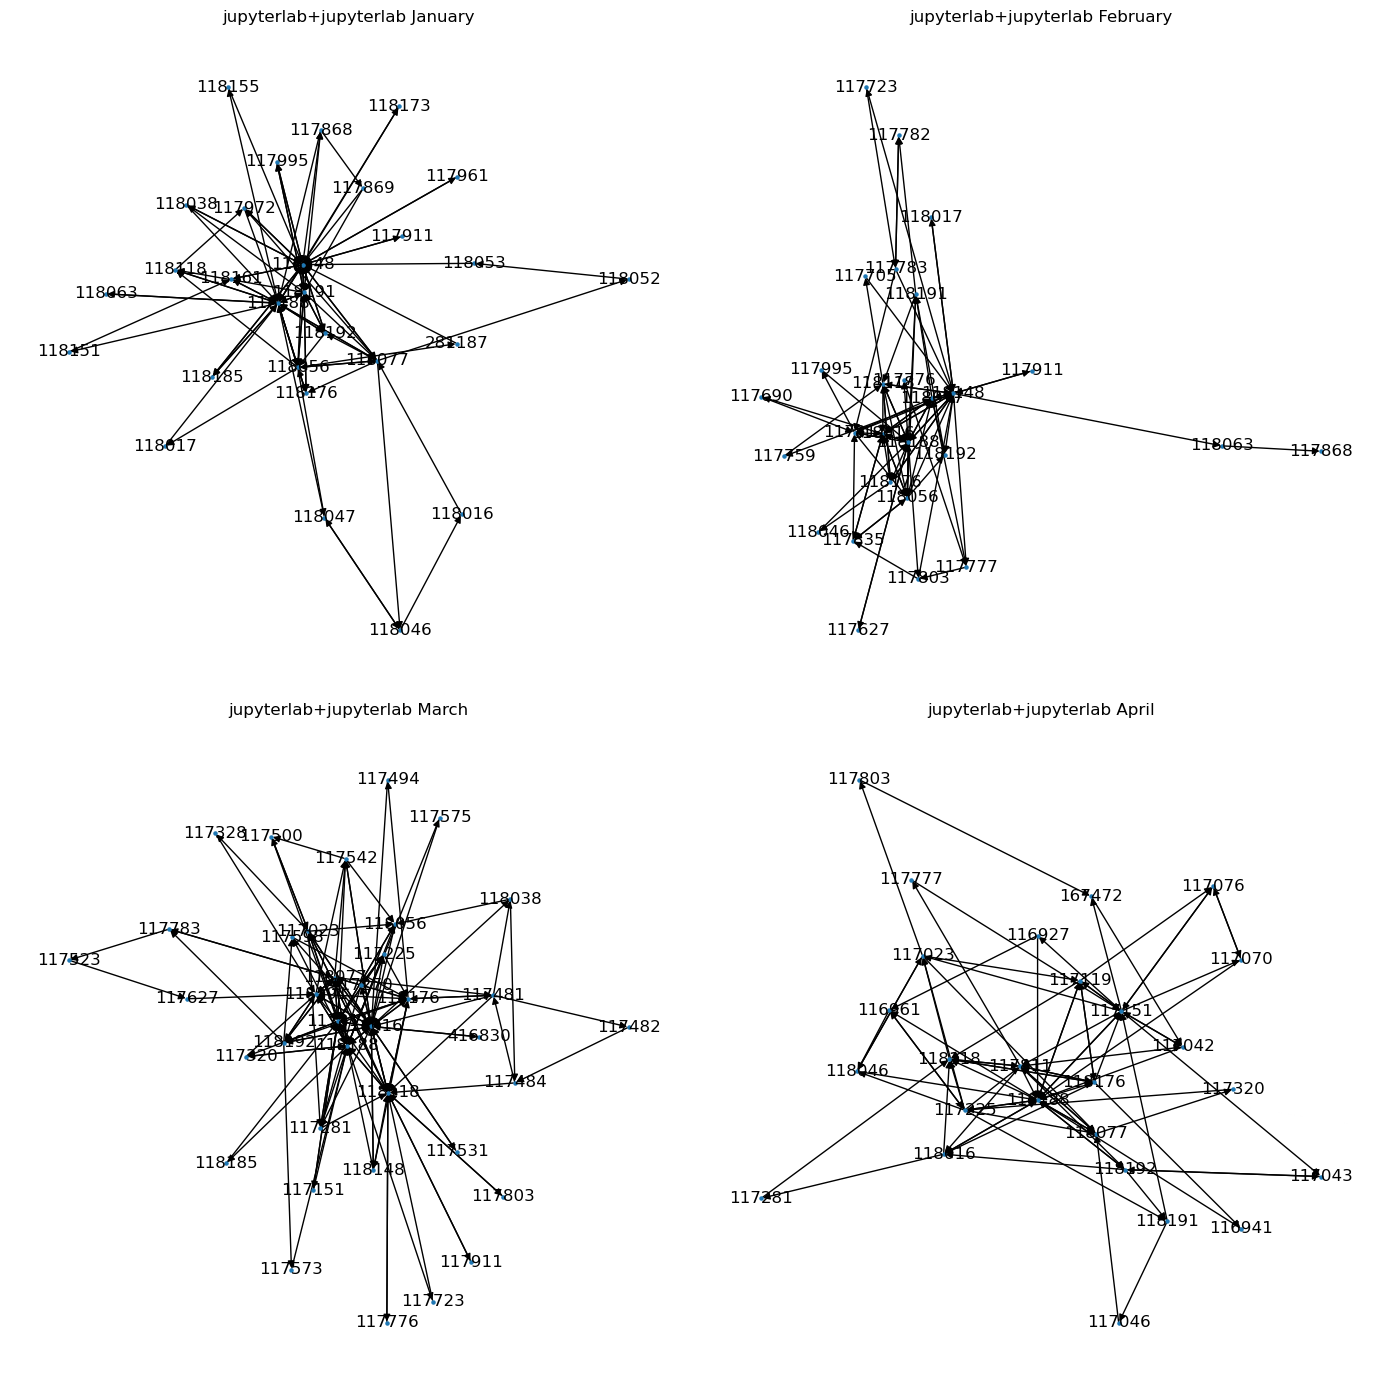

In [37]:
# Lets visualise a sample of the created networks

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))

nx.draw(G_Months["1"], ax=ax1, node_size=5, with_labels=True)
nx.draw(G_Months["2"], ax=ax2, node_size=5, with_labels=True)
ax1.set_title("jupyterlab+jupyterlab January")
ax2.set_title("jupyterlab+jupyterlab February")

nx.draw(G_Months["3"], ax=ax3, node_size=5, with_labels=True)
nx.draw(G_Months["4"], ax=ax4, node_size=5, with_labels=True)
ax3.set_title("jupyterlab+jupyterlab March")
ax4.set_title("jupyterlab+jupyterlab April")

plt.tight_layout()
plt.show()

<br/>
<br/>


### Edit distance

Another means of comparing how different two networks are to quantify what changes (i.e., in the nodes and edges) would need to be made to make one network the same as the other. This can include comparing the 'content' of the network in addition to its raw structure, i.e. where the attributes of nodes and edges are considered.

To do this we can use the concept of "Graph Edit Distance", where:

> Graph edit distance is a graph similarity measure analogous to Levenshtein distance for strings. It is defined as minimum cost of edit path (sequence of node and edge edit operations) transforming graph G1 to graph isomorphic to G2.- NetworkX Documentation

One method for assessing this would be to simply count the number of nodes that need to be removed, the number of missing nodes that need to be added, the number of edges to remove, and the number of missing edges to add. However this may lead to some redundant operations, instead we could also consider a third type of operation 'substitute' to swap nodes and edges.

NetworkX provides several API methods for assessing the edit distance (https://networkx.org/documentation/stable/reference/algorithms/similarity.html), and most notably: 

```python
nx.graph_edit_distance(..)
```
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.graph_edit_distance.html

However, finding the exact edit distance between two graphs/networks is an NP-hard problem. NetworkX as a result is often quite slow to calculate the exact edit distance using the method above. Therefore, it also provides the ability to generate less-optimal 'solutions' which we can expect to be close to the exact edit distance, but not guaranteed.

Two notable methods for this are:

```python
nx.optimize_graph_edit_distance(..)  # Generates edit distance 'solutions' and returns as the total number add, remove, and substitute operations
```
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.optimize_edit_paths.html

and

```python
nx.optimize_edit_paths(..) # Generates edit distance 'solutions' and returns the exact add, remove, and substitute operations in each 
```
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.graph_edit_distance.html

In an analyst task we may only be interested in the edit distance value. However, for demonstration purposes lets use the second method and examine a generated 'solution' for the operations that would be needed to convert, the commit network for January into the *isomorphic equivalent* of the commit network for February. 

**In this first example with the default parameters/arguments, it will ignore node and edge attributes (including node ids) and focus on the changes needed for the January network to become the same Graph structure as February network.**

**Note, in the default parameters, node and edge substitutions have a 'cost' of 0, i.e. they do not contribute to the edit distance. Whereas adding/removing nodes and edges do.**



In [38]:
solutions = nx.optimize_edit_paths(G_Months["1"], G_Months["2"])

# the method returns a Python Generator object for efficiency, not a list

solution = next(solutions)   # move the generator to the first attempted solution

node_changes = solution[0]   # get the list of change operations needed to J's nodes
edge_changes = solution[1]   # get the list of change operations needed to J's edges
edit_distance = solution[2]  # get the edit distance of the solution (# of node change operations + # of edge change operations). same result as calling next(nx.optimize_graph_edit_distance(J, G))

print("Edit distance (Cost): %d" % edit_distance)  # total number of node and edge operations less the number of node substitutions and edge substitutions
print("Total number of node and edge operations: %d" % (len(node_changes)+len(edge_changes)))

print("\nExample node operations (from, to):")
for change in node_changes[:30]: #limit to the first 30 for visualisation purposes
    print(change) 
    # 'None' values in the first position represents a node being added. 
    # 'None' values in the second position represents a node being removed. 
    # values in both positions represent a node substitution 

print("\nExample edge operations (from, to):")
for change in edge_changes[:30]: #limit to the first 30 for visualisation purposes
    print(change)
    # 'None' values in the first position represents an edge being added. 
    # 'None' values in the second position represents an edge being removed. 
    # values in both positions represent an edge substitution 
        

Edit distance (Cost): 117
Total number of node and edge operations: 171

Example node operations (from, to):
('117869', None)
('118191', '118188')
('118056', '117627')
('117868', '118077')
('118188', '118148')
('118148', '117811')
('117995', '118056')
('118038', '117835')
('118118', '118176')
('117972', '118046')
('117911', '118118')
('118077', '118191')
('118192', '117690')
('117961', '117705')
('118176', '117911')
('118046', '117723')
('118016', '117783')
('118017', '118017')
('118047', '117759')
('118052', '117777')
('118053', '117803')
('281187', '117776')
('118063', '117782')
('118161', '118192')
('118151', '117995')
('118155', '118063')
('118185', '117868')
('118173', '118016')

Example edge operations (from, to):
(('117869', '118191'), None)
(('118191', '118056'), ('118188', '117627'))
(('118056', '118191'), ('117627', '118188'))
(('118191', '117868'), ('118188', '118077'))
(('117868', '117869'), None)
(None, ('118077', '118188'))
(('118191', '118188'), ('118188', '118148'))
(('

Some observations:

- The total number of operations (node and edge operations) is larger than the reported edit 'distance'. This is because NetworkX is calculating the edit distance as a 'cost' where node and edge additions/deletions have a cost but substitutions (operations without a 'None' in the first or second position) have a cost of 0.


<br/>

We can loop over the Generator object to have NetworkX keep looking for 'better' solutions, where the edit distance/cost is reduced.

In [39]:
i=0
for solution in solutions:
    print(f"Discovered edit distance: {solution[2]}")
    i+=1
    if i==3: break

Discovered edit distance: 115.0
Discovered edit distance: 113.0
Discovered edit distance: 111.0


<br/>

The default parameters/arguments of NetworkX's edit distance methods focus on the changes needed to make one network the isomorphic equivalent of another. Where node and edge attributes (including ids) are ignored and this is just the underlying graph structure of the networks.

However, we can change this so that, for example, the node ids between the networks are considered. In the case of the GitHub networks, we've seen that the networks for each month often have many shared nodes (where users continue to commit to the repository over the year the data spans).

To do this we need to add the node id as an *attribute* to the node as strictly speaking the node id is kept separate from a node's attributes (like the timezone attribute seen in Section 3 of this notebook). From this we then need to define a new method that NetworkX will use to compare if two nodes are similar or not, and then factor this into the list of operations needed to change one Network into the other.

This example represents a slight step forward in how the nx.optimize_graph_edit_distance(..) and nx.optimize_edit_paths(..) methods can be configured. You may wish to look at the documentation pages for how this can be extended further (e.g., assigning custom edit 'costs' to specific types of operations, defining a custom method for how edges are compared, etc.).


In [40]:
# Create a copy of the January network for convenience and avoid changing the original network.
G1 = G_Months["1"].copy()
# Loop over each of the nodes and add the id of the node as an attribute with the key "label"
for n in G1.nodes():
    G1.nodes[n]["label"] = n

# Repeat the above for the February network
G2 = G_Months["2"].copy()
for n in G2.nodes():
    G2.nodes[n]["label"] = n
    
# Define a custom method for NetworkX to compare whether two nodes are similar or not
def new_node_subst_cost(node1, node2):
    # check if the nodes have exactly the same value for the "label" attribute (which we set as the node id)
    if node1["label"] == node2["label"]:
        return 0 # if the nodes have the same label/id, return an edit cost of 0
    return 1     # otherwise the edit cost is 1


solutions = nx.optimize_edit_paths(
    G1, 
    G2,
    node_subst_cost=new_node_subst_cost  # set the node_subst_cost parameter to be the new node comparison method defined above
)

solution = next(solutions)   # move the generator to the first attempted solution

node_changes = solution[0]   # get the list of change operations needed to J's nodes
edge_changes = solution[1]   # get the list of change operations needed to J's edges
edit_distance = solution[2]  # get the edit distance of the solution (# of node change operations + # of edge change operations). same result as calling next(nx.optimize_graph_edit_distance(J, G))

print(f"Edit distance (Cost): {edit_distance}")  # total number of node and edge operations less the number of node substitutions and edge substitutions
print(f"Total number of node and edge operations: {(len(node_changes)+len(edge_changes))}\n")

print("Example node operations (from, to):")
for change in node_changes[:30]: #limit to the first 30 for visualisation purposes
    print(change) 
    # 'None' values in the first position represents a node being added. 
    # 'None' values in the second position represents a node being removed. 
    # values in both positions represent a node substitution 

print("\nExample edge operations (from, to):")
for change in edge_changes[:30]: #limit to the first 30 for visualisation purposes
    print(change)
    # 'None' values in the first position represents an edge being added. 
    # 'None' values in the second position represents an edge being removed. 
    # values in both positions represent an edge substitution 


Edit distance (Cost): 125.0
Total number of node and edge operations: 169

Example node operations (from, to):
('117869', '117690')
('118191', '118191')
('118056', '118056')
('117868', '117868')
('118188', '118188')
('118148', '118148')
('117995', '117995')
('118038', '117627')
('118118', '118118')
('117972', '117811')
('117911', '117911')
('118077', '118077')
('118192', '118192')
('117961', '117835')
('118176', '118176')
('118046', '118046')
('118016', '118016')
('118017', '118017')
('118047', '117705')
('118052', '117723')
('118053', '117783')
('281187', '117759')
('118063', '118063')
('118161', '117777')
('118151', '117803')
('118155', '117776')
('118185', '117782')
('118173', None)

Example edge operations (from, to):
(('117869', '118191'), None)
(('118191', '118056'), ('118191', '118056'))
(('118056', '118191'), None)
(('118191', '117868'), None)
(('117868', '117869'), None)
(('118191', '118188'), None)
(('118056', '118188'), ('118056', '118188'))
(('117868', '118188'), None)
(('1

<br/>

Again, we can loop over the Generator object to have NetworkX keep looking for 'better' solutions, where the edit distance/cost is reduced.

In [41]:
i=0
for solution in solutions:
    print(f"Discovered edit distance: {solution[2]}")
    i+=1
    if i==3: break

Discovered edit distance: 121.0
Discovered edit distance: 120.0
Discovered edit distance: 119.0


Some observations:

- The edit distance when considering the node ids in the similarity actually increases the edit distance in comparison to just the isomorphic equivalent edit cost.
- Many of the node 'substitutions' have the same node id for both values, showing the effect of the new_node_subst_cost(..) method.


> **Extra**: Create networks for each month for each repository (rather than just January) and explore how the structure and 'content' of the commit behaviour networks for each repository change over time. For example:
> 1. Compare the 12 networks for each repository using a triadic census in the same way as the comparisons across repositories in Part 2 of this notebook.
> 2. Compare the 12 networks for each repository using edit distance in the same way as between January and all months in Part 3 of this notebook.